In [2]:
%matplotlib inline

In [3]:
from pylab import *
%matplotlib notebook

In [4]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
#from matplotlib import rc
import pandas as pd
#from matplotlib import rc

In [6]:
submit = pd.read_csv("/Users/anastasiamarkelova/PycharmProjects/Smart energy/data/submit.csv",sep = ';')
submit

,timestamp,site_id,period_id,actual_consumption,actual_pv,load_00,load_01,load_02,load_03,load_04,...,price_sell_86,price_sell_87,price_sell_88,price_sell_89,price_sell_90,price_sell_91,price_sell_92,price_sell_93,price_sell_94,price_sell_95
0,2015-06-20T19:30:00+03:00,7,1,257.028755,1822.027575,268.862459,286.222688,275.030280,273.802771,273.401496,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
1,2015-06-20T19:45:00+03:00,7,1,287.979862,1711.236750,292.553394,279.644747,273.802771,273.401496,274.639462,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
2,2015-06-20T20:00:00+03:00,7,1,277.214260,1587.439500,275.556470,279.286209,273.401496,274.639462,274.606598,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
3,2015-06-20T20:15:00+03:00,7,1,289.325562,1452.645487,280.851545,276.095437,274.639462,274.606598,273.587886,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
4,2015-06-20T20:30:00+03:00,7,1,277.214260,1308.703350,274.107677,273.719871,274.606598,273.587886,273.679718,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115195,2017-03-14T15:00:00+03:00,12,15,254.197518,1441.887000,270.353683,389.801995,418.450369,451.118229,610.304869,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
115196,2017-03-14T15:15:00+03:00,12,15,283.908916,1463.953906,383.628744,400.204954,425.485671,503.089604,546.317606,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
115197,2017-03-14T15:30:00+03:00,12,15,245.944352,1480.757594,331.558986,399.085377,502.540088,457.696700,532.126988,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
115198,2017-03-14T15:45:00+03:00,12,15,260.800051,1491.482062,362.608034,487.040178,455.033204,460.411817,603.775198,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [104]:
class Battery(object):
    """ Used to store information about the battery.
       :param current_charge: is the initial state of charge of the battery
       :param capacity: is the battery capacity in Wh
       :param charging_power_limit: the limit of the power that can charge the battery in W
       :param discharging_power_limit: the limit of the power that can discharge the battery in W
       :param battery_charging_efficiency: The efficiecny of the battery when charging
       :param battery_discharing_efficiecny: The discharging efficiency
    """
    def __init__(self,
                 current_charge=0.0,
                 capacity=0.0,
                 charging_power_limit=1.0,
                 discharging_power_limit=-1.0,
                 charging_efficiency=0.95,
                 discharging_efficiency=0.95):
        self.current_charge = current_charge
        self.capacity = capacity
        self.charging_power_limit = charging_power_limit
        self.discharging_power_limit = discharging_power_limit
        self.charging_efficiency = charging_efficiency
        self.discharging_efficiency = discharging_efficiency

In [229]:
from ortools.linear_solver import pywraplp
class BatteryContoller():
    step = 960

    def propose_state_of_charge(self,
                                site_id,
                                timestamp,
                                battery,
                                actual_previous_load,
                                actual_previous_pv_production,
                                price_buy,
                                price_sell,
                                load_forecast,
                                pv_forecast):

        self.step -= 1
        number_step = min(96, self.step)
        #
        price_buy = price_buy.tolist()
        price_sell = price_sell.tolist()
        load_forecast = load_forecast.tolist()
        pv_forecast = pv_forecast.tolist()
        #
        energy = [None] * number_step

        energy[i] = load_forecast[i] - pv_forecast[i]
        # battery
        capacity = battery.capacity
        charging_efficiency = battery.charging_efficiency
        discharging_efficiency = 1. / battery.discharging_efficiency
        current = capacity * battery.current_charge
        limit = battery.charging_power_limit
        dis_limit = battery.discharging_power_limit
        limit /= 4.
        dis_limit /= 4.

        # Ortools
        solver = pywraplp.Solver("milp", pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

        # Variables: all are continous
        charge = [solver.NumVar(0.0, limit, "c" + str(i)) for i in range(number_step)]
        dis_charge = [solver.NumVar(dis_limit, 0.0, "d" + str(i)) for i in range(number_step)]
        battery_power = [solver.NumVar(0.0, capacity, "b" + str(i)) for i in range(number_step + 1)]
        grid = [solver.NumVar(0.0, solver.infinity(), "g" + str(i)) for i in range(number_step)]
        mu = [solver.IntVar(0, 1, "l" + str(i)) for i in range(number_step)]

        # Objective function
        objective = solver.Objective()
        for i in range(number_step):
            #objective.SetCoefficient(grid[i], price_buy[i])
            #objective.SetCoefficient(grid_s[i], - price_sell[i])
            objective.SetCoefficient(grid[i], price_buy[i] - price_sell[i])
            objective.SetCoefficient(charge[i], price_sell[i] + price_buy[i] / 1000.)
            objective.SetCoefficient(dis_charge[i], price_sell[i])
        objective.SetMinimization()

        # 3 Constraints
        c_grid = [None] * number_step
        c_power = [None] * (number_step + 1)

        # first constraint
        c_power[0] = solver.Constraint(current, current)
        c_power[0].SetCoefficient(battery_power[0], 1)

        for i in range(0, number_step):
            # second constraint
            c_grid[i] = solver.Constraint(energy[i], solver.infinity())
            c_grid[i].SetCoefficient(grid[i], 1)
            #c_grid[i].SetCoefficient(grid_s[i], -1)
            c_grid[i].SetCoefficient(charge[i], -1)
            c_grid[i].SetCoefficient(dis_charge[i], -1)
            # third constraint
            c_power[i + 1] = solver.Constraint(0, 0)
            c_power[i + 1].SetCoefficient(charge[i], charging_efficiency)
            c_power[i + 1].SetCoefficient(dis_charge[i], discharging_efficiency)
            c_power[i + 1].SetCoefficient(battery_power[i], 1)
            c_power[i + 1].SetCoefficient(battery_power[i + 1], -1)

            #solver.Add(mu[i]+ v[i]<= 1)
            solver.Add(0<=charge[i]<=mu[i]*limit)
            solver.Add((1-mu[i])*dis_limit <= dis_charge[i] <= 0)

        # solve the model
        solver.Solve()

        return battery_power[1].solution_value() / capacity

In [287]:
import numpy as np
import pandas as pd
from copy import deepcopy
from tqdm import tqdm



class Simulation(object):
    """ Handles running a simulation.
    """
    def __init__(self,
                 data,
                 battery,
                 site_id):
        """ Creates initial simulation state based on data passed in.
            :param data: contains all the time series needed over the considered period
            :param battery: is a battery instantiated with 0 charge and the relevant properties
            :param site_id: the id for the site (building)
        """

        self.data = data

        # building initialization
        self.actual_previous_load = self.data.actual_consumption.values[0]
        self.actual_previous_pv = self.data.actual_pv.values[0]

        # align actual as the following, not the previous 15 minutes to
        # simplify simulation
        self.data.loc[:, 'actual_consumption'] = self.data.actual_consumption.shift(-1)
        self.data.loc[:, 'actual_pv'] = self.data.actual_pv.shift(-1)

        self.site_id = site_id
        self.load_columns = data.columns.str.startswith('load_')
        self.pv_columns = data.columns.str.startswith('pv_')
        self.price_sell_columns = data.columns.str.startswith('price_sell_')
        self.price_buy_columns = data.columns.str.startswith('price_buy_')

        # initialize money at 0.0
        self.money_spent = 0.0
        self.money_spent_without_battery = 0.0

        # battery initialization
        self.battery = battery

    def run(self):
        """ Executes the simulation by iterating through each of the data points
            It returns both the electricity cost spent using the battery and the
            cost that would have been incurred with no battery.
        """
        battery_controller = BatteryContoller()
        money_spent_ = []
        money_spent_without_battery_ = []
        grid_energy_ = []
        current_charge_ = []
        current_time_ = []
        price_buy_ = []
        price_sell_ = []

        for current_time, timestep in tqdm(self.data.iterrows(), total=self.data.shape[0], desc=' > > > > timesteps\t'):
            # can't calculate results without actual, so skip (should only be last row)
            if pd.notnull(timestep.actual_consumption):
                proposed_state_of_charge = battery_controller.propose_state_of_charge(
                    self.site_id,
                    current_time,
                    deepcopy(self.battery),
                    self.actual_previous_load,
                    self.actual_previous_pv,
                    timestep[self.price_buy_columns],
                    timestep[self.price_sell_columns],
                    timestep[self.load_columns],
                    timestep[self.pv_columns])

        # get energy required to achieve the proposed state of charge
                grid_energy, battery_energy_change = self.simulate_battery_charge(self.battery.current_charge,
                                                                          proposed_state_of_charge,
                                                                          timestep.actual_consumption,
                                                                          timestep.actual_pv)

                grid_energy_without_battery = timestep.actual_consumption - timestep.actual_pv

        # buy or sell energy depending on needs
                price = timestep.price_buy_00 if grid_energy >= 0 else timestep.price_sell_00
                price_without_battery = timestep.price_buy_00 if grid_energy_without_battery >= 0 else timestep.price_sell_00

        # calculate spending based on price per kWh and energy per Wh
                self.money_spent += grid_energy * (price / 1000.)
                self.money_spent_without_battery += grid_energy_without_battery * (price_without_battery / 1000.)

        # update current state of charge
                self.battery.current_charge += battery_energy_change / self.battery.capacity
                self.actual_previous_load = timestep.actual_consumption
                self.actual_previous_pv = timestep.actual_pv 
                money_spent_.append(self.money_spent)
                money_spent_without_battery_.append(self.money_spent_without_battery)
                grid_energy_.append(grid_energy)
                current_charge_.append(self.battery.current_charge)
                current_time_.append(current_time)
                price_buy_.append(timestep.price_buy_00)
                price_sell_.append(timestep.price_sell_00)

        return   current_time_,grid_energy_, current_charge_, money_spent_, money_spent_without_battery_, price_buy_, price_sell_ 

    def simulate_timestep(self, battery_controller, current_time, timestep):
        """ Executes a single timestep using `battery_controller` to get
            a proposed state of charge and then calculating the cost of
            making those changes.
            :param battery_controller: The battery controller
            :param current_time: the timestamp of the current time step
            :param timestep: the data available at this timestep
        """
        # get proposed state of charge from the battery controller
        proposed_state_of_charge = battery_controller.propose_state_of_charge(
            self.site_id,
            current_time,
            deepcopy(self.battery),
            self.actual_previous_load,
            self.actual_previous_pv,
            timestep[self.price_buy_columns],
            timestep[self.price_sell_columns],
            timestep[self.load_columns],
            timestep[self.pv_columns]
        )

        # get energy required to achieve the proposed state of charge
        grid_energy, battery_energy_change = self.simulate_battery_charge(self.battery.current_charge,
                                                                          proposed_state_of_charge,
                                                                          timestep.actual_consumption,
                                                                          timestep.actual_pv)

        grid_energy_without_battery = timestep.actual_consumption - timestep.actual_pv

        # buy or sell energy depending on needs
        price = timestep.price_buy_00 if grid_energy >= 0 else timestep.price_sell_00
        price_without_battery = timestep.price_buy_00 if grid_energy_without_battery >= 0 else timestep.price_sell_00

        # calculate spending based on price per kWh and energy per Wh
        self.money_spent += grid_energy * (price / 1000.)
        self.money_spent_without_battery += grid_energy_without_battery * (price_without_battery / 1000.)

        # update current state of charge
        self.battery.current_charge += battery_energy_change / self.battery.capacity
        self.actual_previous_load = timestep.actual_consumption
        self.actual_previous_pv = timestep.actual_pv

    def simulate_battery_charge(self, initial_state_of_charge, proposed_state_of_charge, actual_consumption, actual_pv):
        """ Charges or discharges the battery based on what is desired and
            available energy from grid and pv.
            :param initial_state_of_charge: the current state of the battery
            :param proposed_state_of_charge: the proposed state for the battery
            :param actual_consumption: the actual energy consumed by the building
            :param actual_pv: the actual pv energy produced and available to the building
        """
        # charge is bounded by what is feasible
        proposed_state_of_charge = np.clip(proposed_state_of_charge, 0.0, 1.0)

        # calculate proposed energy change in the battery
        target_energy_change = (proposed_state_of_charge - initial_state_of_charge) * self.battery.capacity

        # efficiency can be different whether we intend to charge or discharge
        if target_energy_change >= 0:
            efficiency = self.battery.charging_efficiency
            target_charging_power = target_energy_change / ((15. / 60.) * efficiency)
        else:
            efficiency = self.battery.discharging_efficiency
            target_charging_power = target_energy_change * efficiency / (15. / 60.)

        # actual power is bounded by the properties of the battery
        actual_charging_power = np.clip(target_charging_power,
                                        self.battery.discharging_power_limit,
                                        self.battery.charging_power_limit)

        # actual energy change is based on the actual power possible and the efficiency
        if actual_charging_power >= 0:
            actual_energy_change = actual_charging_power * (15. / 60.) * efficiency
        else:
            actual_energy_change = actual_charging_power * (15. / 60.) / efficiency

        # what we need from the grid = (the power put into the battery + the consumption) - what is available from pv
        grid_energy = (actual_charging_power * (15. / 60.) + actual_consumption) - actual_pv

        # if positive, we are buying from the grid; if negative, we are selling
        return grid_energy, actual_energy_change


if __name__ == '__main__':
    # load available metadata to determine the runs
    metadata_path = '/Users/anastasiamarkelova/PycharmProjects/Smart energy/data/metadata.csv'
    metadata = pd.read_csv(metadata_path, index_col=0,sep = ";")
    metadata = metadata[metadata.index ==1]

    # store results of each run
    results = []

    # # execute two runs with each battery for every row in the metadata file:
    for site_id, parameters in tqdm(metadata.iterrows(), desc='sites\t\t\t', total=metadata.shape[0]):
        site_data_path = '/Users/anastasiamarkelova/PycharmProjects/Smart energy/data/submit'+ str(site_id)+'.csv'

        site_data = pd.read_csv(site_data_path, parse_dates=['timestamp'], sep=';',index_col='timestamp')
                
        for batt_id in tqdm([1], desc=' > batteries \t\t'):
                # create the battery for this run
                # (Note: Quantities in kW are converted to watts here)
                batt = Battery(capacity=parameters[f"Battery_{batt_id}_Capacity"] * 1000,
                               charging_power_limit=parameters[f"Battery_{batt_id}_Power"] * 1000,
                               discharging_power_limit=-parameters[f"Battery_{batt_id}_Power"] * 1000,
                               charging_efficiency=parameters[f"Battery_{batt_id}_Charge_Efficiency"],
                               discharging_efficiency=parameters[f"Battery_{batt_id}_Discharge_Efficiency"])

                # execute the simulation for each simulation period in the data
                n_periods = site_data.period_id.nunique()
                for g_id, g_df in tqdm(site_data.groupby('period_id'), total=n_periods, desc=' > > periods\t\t'):
                    # reset battery to no charge before simulation
                    batt.current_charge = 0
                    sim = Simulation(g_df, batt, site_id)
                    current_time_,grid_energy_, current_charge_, money_spent, money_no_batt, price_buy_, price_sell_  = sim.run()

                    # store the results
                    results.append({
                        'run_id': f"{site_id}_{batt_id}_{g_id}",
                        'site_id': site_id,
                        'battery_id': batt_id,
                        'period_id': g_id,
                        "current_time":list(current_time_),
                        'grid_energy':list(grid_energy_),
                        'current_charge':list(current_charge_),
                        'money_spent': list(money_spent),
                        'money_no_batt': list(money_no_batt),
                        'price_buy': list(price_buy_),
                        'price_sell':list(price_sell_),
                        'score': (money_spent[len(money_spent)-1] - money_no_batt[len(money_spent)-1]) / np.abs(money_no_batt[len(money_spent)-1]),})
                    break 
    
    # write all results out to a file
    results_df = pd.DataFrame(results).set_index('run_id')
    results_df = results_df[['site_id', 'battery_id', 'period_id',"current_time",'grid_energy','current_charge','money_spent', 'money_no_batt', 'price_buy','price_sell','score']]
    results_df.to_csv('results_milp.csv')

 > batteries 		:   0%|          | 0/1 [00:00<?, ?it/s]

 > > periods		:   0%|          | 0/10 [00:00<?, ?it/s]


 > > > > timesteps	:   0%|          | 0/960 [00:00<?, ?it/s]


 > > > > timesteps	:   1%|▏         | 14/960 [00:00<00:06, 138.45it/s]


 > > > > timesteps	:   3%|▎         | 28/960 [00:00<00:07, 121.35it/s]


 > > > > timesteps	:   4%|▍         | 41/960 [00:00<00:08, 108.44it/s]


 > > > > timesteps	:   6%|▌         | 53/960 [00:00<00:08, 110.89it/s]


 > > > > timesteps	:   7%|▋         | 67/960 [00:00<00:07, 118.15it/s]


 > > > > timesteps	:   8%|▊         | 79/960 [00:00<00:08, 100.03it/s]


 > > > > timesteps	:  10%|▉         | 95/960 [00:00<00:07, 116.31it/s]


 > > > > timesteps	:  11%|█▏        | 108/960 [00:00<00:07, 116.67it/s]


 > > > > timesteps	:  13%|█▎        | 121/960 [00:01<00:07, 116.41it/s]


 > > > > timesteps	:  14%|█▍        | 135/960 [00:01<00:06, 120.26it/s]


 > > > > timesteps	:  15%|█▌        | 148/960 [00:01<00:06, 122.09it/s]


 > > > > timestep

In [288]:
results_MILP = pd.read_csv('results_milp.csv')
results_MILP = results_MILP[results_MILP.period_id == 1][results_MILP.battery_id== 1]

current_charge_MILP = []
for i in results_MILP.current_charge[0].replace("[", "").replace("]", "").replace(" ", "").split(','):
    current_charge_MILP.append(float(i))
    
grid_energy_MILP = []
for i in results_MILP.grid_energy[0].replace("[", "").replace("]", "").replace(" ", "").split(','):
    grid_energy_MILP.append(float(i))

In [8]:
submit = submit[submit.site_id == 31]

<IPython.core.display.Javascript object>


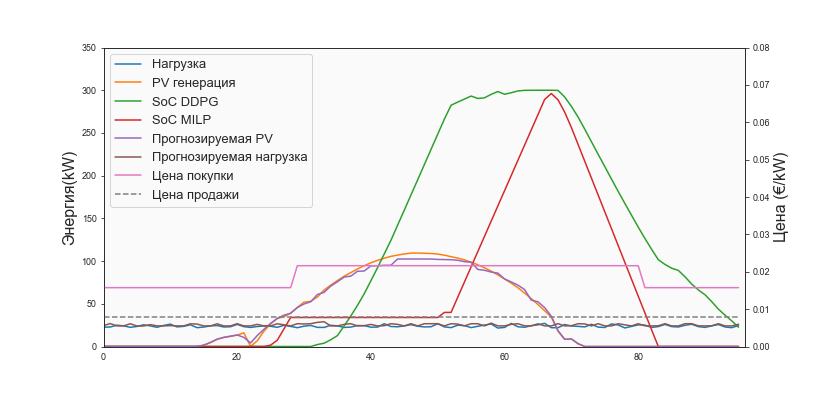

(0.0, 96.0)

In [302]:
id_site = 31
bat_id = 2
id_period =1
pickle_path = "/Users/anastasiamarkelova/PycharmProjects/Smart energy/analysis_of_results/DDPG/norm_s" + str(id_site) + ".p"
with open(pickle_path, "rb") as f:
     norm = pickle.load(f)
pickle_path = "/Users/anastasiamarkelova/PycharmProjects/Smart energy/analysis_of_results/env_DDPG/env_s" + str(id_site) +  "_b"+str(bat_id)+"_p"   + str(id_period) + ".p"
with open(pickle_path, "rb") as f:
     t = pickle.load(f)
        
(battery_charge, battery_energy, actual_consumption, actual_pv, grid_energy,price_sell, price_buy, money_saved, score) = t
# plot params

sns.set_style("white", {"axes.facecolor": ".98"})

fig = plt.figure(tight_layout=False, figsize=(11.5, 5.5))

fontsize_ns = 24
fontsize_sub = 20

savings = np.cumsum(money_saved) / np.sum(money_saved) / 20.
plot(actual_consumption.values[575:671]/1000)
plot(actual_pv.values[575:671]/1000)
plot(np.array(battery_energy[575:671])/1000)
plot(np.array(current_charge_MILP[575:671])*300)#
plot(np.array(submit.iloc[575][100:196])/1000)
plot(np.array(submit.iloc[575][4:100])/1000)
plt.ylabel('Энергия(kW)', fontsize=16)
plt.tick_params(labelsize=9)
plt.ylim([-0,350])
plt.xlim([0,960])
twinx()
plot(price_buy.values[0]*norm['price'])
plot(price_buy.values[0]*norm['price'])
plot(price_buy.values[0]*norm['price'])
plot(price_buy.values[0]*norm['price'])
plot(price_buy.values[0]*norm['price'])
plot(price_buy.values[0]*norm['price'])
plot(price_buy.values[575:671]*norm['price'])
plot(price_sell.values[575:671]*norm['price'], linestyle='--')
plt.legend(['Нагрузка', 'PV генерация', 'SoC DDPG','SoC MILP','Прогнозируемая PV','Прогнозируемая нагрузка','Цена покупки', 'Цена продажи',''], fontsize=13, loc=2)
plt.ylabel('Цена (€/kW)', fontsize=16)
plt.tick_params(labelsize=9)
plt.tick_params(labelsize=9)
plt.ylim([0,0.08])
plt.xlim([0,96])